In [2]:
!pip install noisereduce -q
!pip install PersianG2P -q
!pip install pyloudnorm -q

In [ ]:
import numpy as np
import pandas as pd
import random
import re
import os
import pathlib
import shutil
import librosa
import matplotlib.pyplot as  plt
import IPython.display as ipd
import seaborn as sns
import noisereduce as nr
import soundfile as sf
import json
import pyloudnorm as pyln
import warnings
import ast
import yaml



from collections import Counter
from sklearn.model_selection import train_test_split
from PersianG2p import Persian_g2p_converter
from hazm import Normalizer, word_tokenize
from tqdm import tqdm
from num2fawords import words  

tqdm.pandas()

# Importing Dataset & EDA

In [5]:
manatts_path = "/kaggle/input/persian-tts-dataset-manatts/manatts_dataset.parquet"
manatts_dataset = pd.read_parquet(manatts_path)

In [6]:
manatts_dataset = manatts_dataset.dropna()

In [7]:
manatts_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4992 entries, 3942 to 1313
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   file name      4992 non-null   object 
 1   transcript     4992 non-null   object 
 2   duration       4992 non-null   float64
 3   match quality  4992 non-null   object 
 4   hypothesis     4992 non-null   object 
 5   CER            4992 non-null   float64
 6   search type    4992 non-null   int64  
 7   ASRs           4992 non-null   object 
 8   audio          4992 non-null   object 
 9   samplerate     4992 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 429.0+ KB


In [8]:
manatts_dataset.describe()

duration          CER  search type  samplerate
count  4992.000000  4992.000000  4992.000000      4992.0
mean      4.712658     0.058772     1.024639     44100.0
std       2.221011     0.076581     0.155039         0.0
min       0.000000     0.000000     1.000000     44100.0
25%       2.987982     0.019608     1.000000     44100.0
50%       4.108481     0.044118     1.000000     44100.0
75%       6.048254     0.076923     1.000000     44100.0
max      11.994989     1.120000     2.000000     44100.0

In [9]:
# printing features
manatts_dataset.columns.tolist()

['file name',
 'transcript',
 'duration',
 'match quality',
 'hypothesis',
 'CER',
 'search type',
 'ASRs',
 'audio',
 'samplerate']

In [ ]:
# playing an audio and showing text
random_place = random.randint(0, len(manatts_dataset))
audio_info_row = manatts_dataset.iloc[random_place]

print("The Transcript is: \n", audio_info_row["transcript"])
ipd.Audio(audio_info_row["audio"], rate=audio_info_row["samplerate"])


The Transcript is: 
 فارسی دارای یک وجه مشترک‌اند و بریل فارسی را فراهم ساخته بود و بسیاری از مشکلات که در 


In [ ]:
manatts_dataset.sample(1)[['file name', 'transcript', 'hypothesis', 'match quality']]

file name                                         transcript  \
6395  400-93.wav  در برخی موارد، انکار تا بدانجا پیش می‌رود که و...   

                                             hypothesis match quality  
6395  در برخی موارد انگار تا به دانجا پیش میرود که و...        MIDDLE

In [12]:
manatts_dataset['duration'].describe()

count    4992.000000
mean        4.712658
std         2.221011
min         0.000000
25%         2.987982
50%         4.108481
75%         6.048254
max        11.994989
Name: duration, dtype: float64

In [13]:
manatts_dataset['match quality'].value_counts()


match quality
HIGH      2801
MIDDLE    2104
REJECT      87
Name: count, dtype: int64

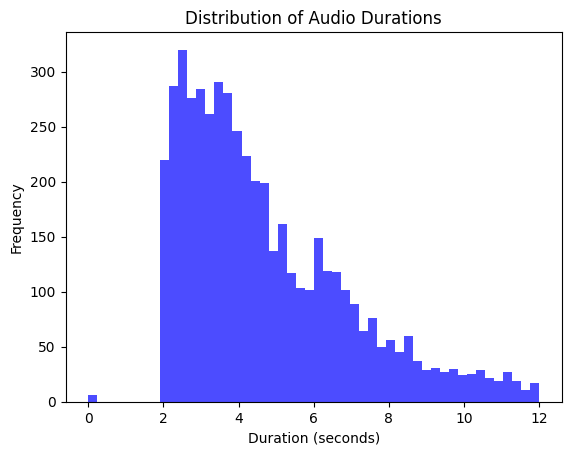

In [14]:
plt.hist(manatts_dataset['duration'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


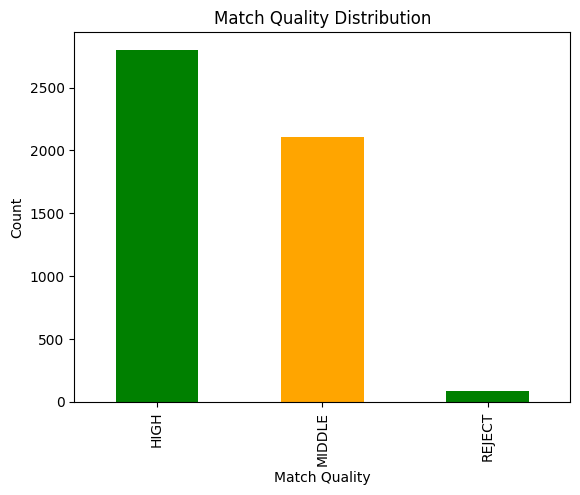

In [15]:
manatts_dataset['match quality'].value_counts().plot(kind='bar', color=['green', 'orange'])
plt.title('Match Quality Distribution')
plt.xlabel('Match Quality')
plt.ylabel('Count')
plt.show()


In [16]:
reject_rows = manatts_dataset[manatts_dataset['match quality'] == 'REJECT']
random_reject_index = random.randint(0, len(reject_rows))
print(reject_rows.iloc[random_reject_index])

audio_info_row = reject_rows.iloc[random_reject_index]

print("The Transcript is: \n", audio_info_row["transcript"])
ipd.Audio(audio_info_row["audio"], rate=audio_info_row["samplerate"])

file name                                                150-6.wav
transcript                   لوگوی نسل مانا به خط خط بریل، با رنگ 
duration                                                  3.562993
match quality                                               REJECT
hypothesis                      لگوی نسلمانا با تکنیک تایکپورگرافی
CER                                                       0.514286
search type                                                      2
ASRs             ['Wav2Vec', 'Vosk', 'Tuned Wav2Vec', 'Whisper'...
audio            [-0.00018310546875, -0.000244140625, -0.000549...
samplerate                                                 44100.0
Name: 5608, dtype: object
The Transcript is: 
 لوگوی نسل مانا به خط خط بریل، با رنگ 


In [17]:
reject_rows = manatts_dataset[manatts_dataset['match quality'] == 'MIDDLE']
print(reject_rows.iloc[0])

audio_info_row = reject_rows.iloc[0]

print("The Transcript is: \n", audio_info_row["transcript"])
print("The Hypothesis is: \n", audio_info_row["hypothesis"])
ipd.Audio(audio_info_row["audio"], rate=audio_info_row["samplerate"])

file name                                               451-15.wav
transcript       باید خودمان را بخشی از مردم بدانیم که مثل آن‌ه...
duration                                                 11.095986
match quality                                               MIDDLE
hypothesis       باید خود را بخشی از مردم بدانیم که مثل آن‌ها ن...
CER                                                       0.085714
search type                                                      1
ASRs                                                   ['Wav2Vec']
audio            [-6.103515625e-05, -0.0001220703125, -0.000122...
samplerate                                                 44100.0
Name: 3942, dtype: object
The Transcript is: 
 باید خودمان را بخشی از مردم بدانیم که مثل آن‌ها نقاط ضعف و قوتی داریم و ممکن است گاهی رسانه به این نقاط ضعف و قوت ما با نگاه متفاوتی بپردازد. 
The Hypothesis is: 
 باید خود را بخشی از مردم بدانیم که مثل آن‌ها نقاط زعف و قدرتی داریم و ممکن است لاهی رسانه به این نقاط زفاقوت ما با نگاه

In [18]:
# pruning reject rows for better training
manatts_dataset = manatts_dataset[manatts_dataset['match quality'] != 'reject'].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


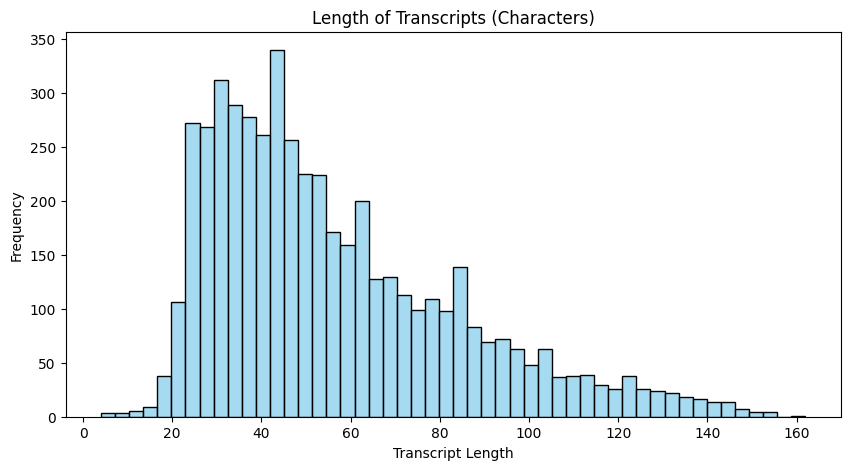

In [19]:
manatts_dataset['transcript_len'] = manatts_dataset['transcript'].apply(len)

# Plot histogram of transcript length
plt.figure(figsize=(10, 5))
sns.histplot(manatts_dataset['transcript_len'], bins=50, color='skyblue')
plt.title("Length of Transcripts (Characters)")
plt.xlabel("Transcript Length")
plt.ylabel("Frequency")
plt.show()

In [20]:
manatts_dataset["transcript_len"].describe()

count    4992.000000
mean       56.491587
std        27.971497
min         4.000000
25%        35.000000
50%        49.000000
75%        72.000000
max       162.000000
Name: transcript_len, dtype: float64

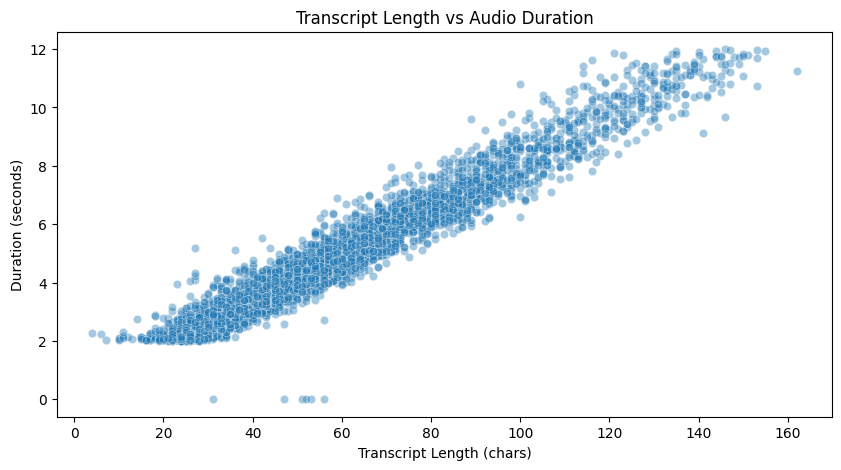

🔍 Correlation between transcript length and duration: 0.97


In [21]:
# Relationship: Transcript Length vs Duration
plt.figure(figsize=(10, 5))
sns.scatterplot(x='transcript_len', y='duration', data=manatts_dataset, alpha=0.4)
plt.title("Transcript Length vs Audio Duration")
plt.xlabel("Transcript Length (chars)")
plt.ylabel("Duration (seconds)")
plt.show()

# Calculate correlation
correlation = manatts_dataset['transcript_len'].corr(manatts_dataset['duration'])
print(f"🔍 Correlation between transcript length and duration: {correlation:.2f}")


🧾 Total unique words: 7528

🔝 Top 10 most frequent words:
[('و', 2833), ('در', 1754), ('به', 1645), ('از', 1383), ('می', 1369), ('که', 1250), ('را', 1059), ('این', 1018), ('با', 804), ('های', 801), ('است', 763), ('برای', 548), ('ها', 502), ('آن', 429), ('یک', 400), ('هم', 340), ('کند', 254), ('افراد', 250), ('شود', 249), ('خود', 239)]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


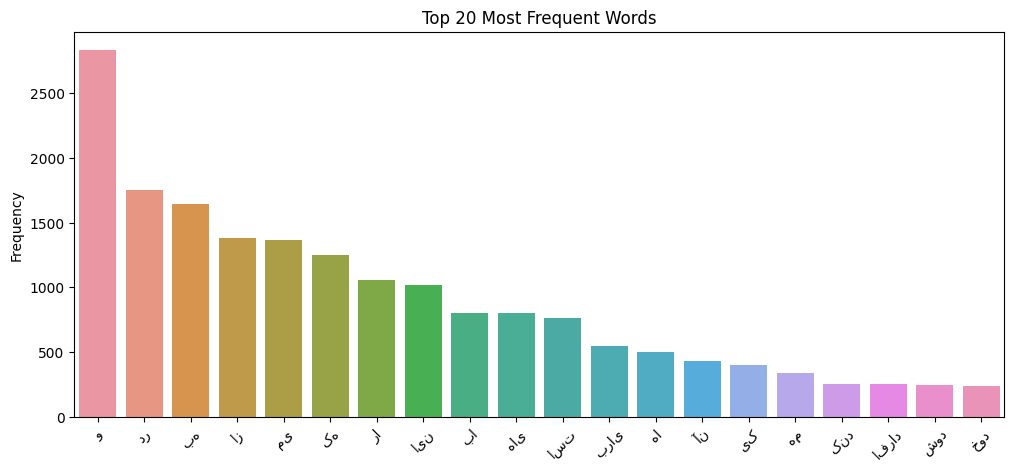

In [22]:
# distinct words
# Tokenize all transcripts (simple whitespace-based tokenizer)
all_words = []
for text in manatts_dataset['transcript']:
    words = re.findall(r'\w+', text)
    all_words.extend(words)

word_freq = Counter(all_words)
print(f"\n🧾 Total unique words: {len(word_freq)}")
print("\n🔝 Top 10 most frequent words:")
print(word_freq.most_common(20))

# Plot top 20 words
top_words = word_freq.most_common(20)
words, counts = zip(*top_words)
plt.figure(figsize=(12, 5))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.ylabel("Frequency")
plt.show()


🔻 Words with the minimum frequency (1 occurrence):
['قوتی', 'جعبۀ', 'شنی', 'استثنای', 'بازه', 'چاقی', 'عروقی', 'مهری', 'تعهدی', 'جدیت', 'آجیل', 'چهارمغز', 'خجالت', 'آوانامه', 'خواهان', 'پاهایتان', 'دوربینی', 'پدرها', 'اولیای', 'ترفند']


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1728 (\N{ARABIC LETTER HEH WITH YEH ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)


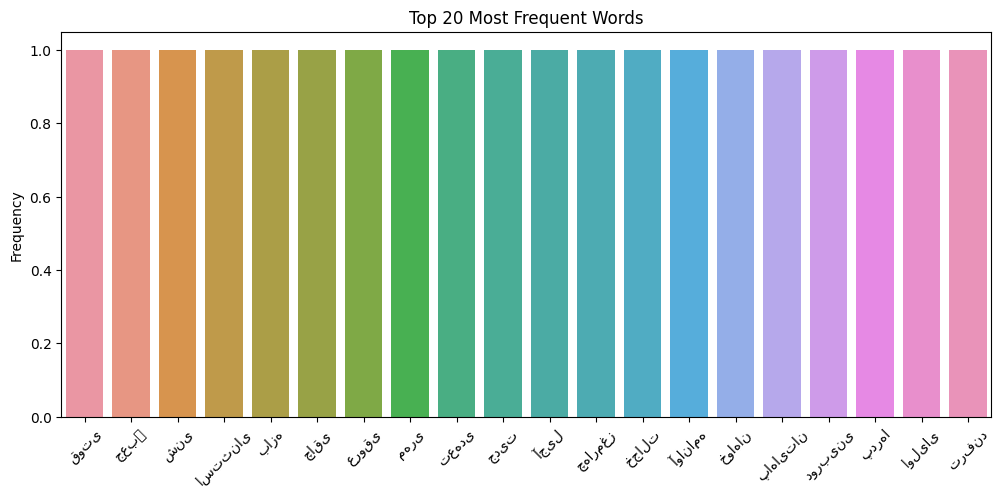

In [23]:
min_freq = min(word_freq.values())
rarest_words = [word for word, freq in word_freq.items() if freq == min_freq]
print(f"\n🔻 Words with the minimum frequency ({min_freq} occurrence):")
print(rarest_words[:20])

# Plot top 20 words
rarest_word_counts = [(word, word_freq[word]) for word in rarest_words[:20]]
words, counts = zip(*rarest_word_counts)
plt.figure(figsize=(12, 5))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.ylabel("Frequency")
plt.show()

In [24]:
assert 'transcript' in manatts_dataset.columns and 'duration' in manatts_dataset.columns, "Missing required columns."

# 1. Total Duration
total_duration_sec = manatts_dataset['duration'].sum()
total_duration_min = total_duration_sec / 60
total_duration_hr = total_duration_min / 60

# 2. Count of all valid (non-empty) transcripts
valid_transcripts = manatts_dataset['transcript'].dropna().astype(str)
sentence_count = valid_transcripts.shape[0]

# 3. Find the longest sentence (by character length)
longest_sentence = valid_transcripts.loc[valid_transcripts.str.len().idxmax()]
longest_length = len(longest_sentence)

# 4. Total number of tokens (split by whitespace)
total_tokens = valid_transcripts.apply(lambda x: len(x.split())).sum()

# === Results ===
print(f"Total duration: {total_duration_sec:.2f} seconds")
print(f"Total duration: {total_duration_min:.2f} minutes")
print(f"Total duration: {total_duration_hr:.2f} hours\n")

print(f"Total number of sentences: {sentence_count}")
print(f"Longest sentence (by characters):\n{longest_sentence}")
print(f"Length of longest sentence: {longest_length} characters\n")

print(f"Total number of tokens: {total_tokens}")


Total duration: 23525.59 seconds
Total duration: 392.09 minutes
Total duration: 6.53 hours

Total number of sentences: 4992
Longest sentence (by characters):
خود را در پیش می‌گیرد. به این نتیجه رسیده‌ام که گاهی باید بنشینیم و به فرزندمان گوش دهیم. در این صورت قادر خواهیم بود رفتارهایش را حدس بزنیم و خود را تطبیق دهیم. 
Length of longest sentence: 162 characters

Total number of tokens: 52412



📊 Match Quality Distribution:
match quality
HIGH      2801
MIDDLE    2104
REJECT      87
Name: count, dtype: int64


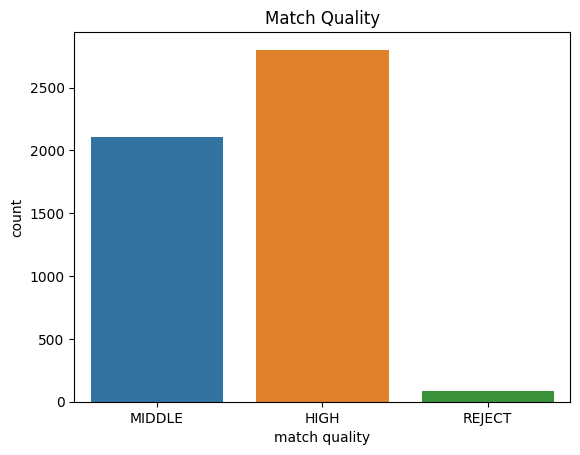

In [25]:
# Match Quality Distribution
print("\n📊 Match Quality Distribution:")
print(manatts_dataset['match quality'].value_counts())

sns.countplot(x='match quality', data=manatts_dataset)
plt.title("Match Quality")
plt.show()

In [26]:
# Filter rows that contain the word  (case-insensitive)
word = r'\bضرب\b'
filtered_df = manatts_dataset[manatts_dataset['transcript'].str.contains(word, case=False, na=False)]

# Count how many times it appears
count = filtered_df.shape[0]

# Show shape of filtered DataFrame
print("Filtered shape:", filtered_df.shape)

# Optional: print the count directly
print(f"'{word}' appears in {count} rows.")

print("The text is: ", filtered_df["transcript"])
filtered_df

Filtered shape: (1, 11)
'\bضرب\b' appears in 1 rows.
The text is:  2950    ولی متأسفانه کمتر به آن توجه شده است و پژوهشگر...
Name: transcript, dtype: object


file name                                         transcript  duration  \
2950  549-69.wav  ولی متأسفانه کمتر به آن توجه شده است و پژوهشگر...  7.036984   

     match quality                                         hypothesis  \
2950        MIDDLE  ولی متاسفانه کمتر به آن توجه شده است و پژوهش گ...   

           CER  search type         ASRs  \
2950  0.103896            1  ['Wav2Vec']   

                                                  audio  samplerate  \
2950  [-0.000274658203125, -0.00048828125, -0.000518...     44100.0   

      transcript_len  
2950              78

# Preprocessing Dataset

**Text Processing:**

✅ Goals:

1️⃣ Removing Unwanted Character (Like %, #,....) And Convert that into word (if needed, like * → Multiply or ( → Open Parenthesis) 

2️⃣ Convert Digits To Persian Or Most Important Symbols Into Persian

3️⃣ Normalize The Persian Text

4️⃣ Converting Into Phoneme

---------------

**Audio Processing:**

✅ Goals:

1️⃣ Converting Into Mono

2️⃣ Down Sampling The Audio (16000 Hz)

3️⃣ Normalization The Audio

4️⃣ Trim Silence

5️⃣ Normalizing The Loudness (target dBFS)

6️⃣ Denoising 

**The General Preprocessing For both of them:**\
Filter out very long and very short samples\
Text token length filtering (min/max word/token count)\
Audio duration filtering (remove very short/long audios)\
Align audio–text length ratio

In [27]:
# making a processed folder
MAIN_DATASET = "/kaggle/working/manatts_dataset_training"
SAVE_AUDIO_DIR = "/kaggle/working/manatts_dataset_training/processed_audio"
os.makedirs(MAIN_DATASET, exist_ok=True)
os.makedirs(SAVE_AUDIO_DIR, exist_ok=True)

In [28]:
# removing unwanted character and text cleaning
replacements = {
        '%': ' درصد ',
        '*': ' ضرب ',
        '×': ' ضرب ',
        '+': ' جمع ',
        '-': ' منفی ',
        '=': ' مساوی ',
        '/': ' تقسیم ',
        '÷': ' تقسیم ',
        '(': ' پرانتز باز ',
        ')': ' پرانتز بسته ',
        '[': ' براکت باز ',
        ']': ' براکت بسته ',
        '{': ' آکولاد باز ',
        '}': ' آکولاد بسته ',
        '<': ' کوچکتر ',
        '>': ' بزرگتر ',
        '#': ' هشتگ ',
        '@': ' ادساین',
        '^': ' توان ',
        '&': ' و ',
        '$': ' دلار ',
        '|': ' یا ',
        ',': '',
        '،': '',
        '\\': '',
        '"': ' کوتیشن ',
        '\'': ' اسلش ',
        '`': '',
        '~': ' نقیض ',
    }

def load_swears(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as f:
        swears = json.load(f)
    return swears

def clean_text(text, swears):
    # Replace symbols with Persian words
    if replacements:
        for symbol, rep in replacements.items():
            text = text.replace(symbol, rep)
    # Remove emojis and unwanted symbols except Persian/English letters, digits, and space
    text = re.sub(r'[^\w\s\u0600-\u06FF۰-۹۱۲۳۴۵۶۷۸۹،]', '', text, flags=re.UNICODE)

    # Remove swear words
    for swear in swears["word"]:
        pattern = r'\b' + r'\u200b?'.join(re.escape(c) for c in swear) + r'\b'
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)


    # 4. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text



In [29]:
sample_text = "سلام! این، محصول 50% تخفیف داره 😡 (خریدمش)"
swears = load_swears("/kaggle/input/persian-swear-data/Persian Swear.json")
cleaned = clean_text(sample_text, swears)
print(cleaned)

سلام این محصول 50 درصد تخفیف داره پرانتز باز خریدمش پرانتز بسته


In [30]:
# Converting digits or symbols into Persian

# Currency mapping
currency_map = {
    '$': 'دلار',
    '€': 'یورو',
    '£': 'پوند',
    '₽': 'روبل',
    '¥': 'ین',
    'تومان': 'تومان',
    'ریال': 'ریال'
}

def convert_numbers_to_persian_words(text):
    def currency_replacer(match):
        number = match.group(1)
        currency = match.group(2)
        try:
            num_word = words(float(number))
        except:
            num_word = number
        currency_word = currency_map.get(currency, currency)
        return f'{num_word} {currency_word}'

    text = re.sub(r'(\d+(?:\.\d+)?)(?:\s*)(\$|€|£|₽|¥|تومان|ریال)', currency_replacer, text)

    def number_to_word(match):
        try:
            return words(float(match.group()))
        except:
            return match.group()

    text = re.sub(r'\d+(?:\.\d+)?', number_to_word, text)
    return text


In [31]:
text = "او 45 تومان داشت، 3.14 دلار خرج کرد و 12€ دیگر برای قهوه داد."
print(convert_numbers_to_persian_words(text))

او 45 تومان داشت، 3.14 دلار خرج کرد و 12 یورو دیگر برای قهوه داد.


In [32]:
# Normalization Text
normalizer = Normalizer()

def normalize_text(text):
    # Normalize text (standard Persian forms)
    text = normalizer.normalize(text)
    
    return text


In [33]:
text = "سلام خوبی چرا جواب تماس رو نمیدی؟ میخواستم درباره ی دایناسورها توضیح بدم"
print(normalize_text(text))

سلام خوبی چرا جواب تماس رو نمیدی؟ می‌خواستم درباره‌ی دایناسورها توضیح بدم


In [34]:
# Converting text into phoneme
PersianG2Pconverter = Persian_g2p_converter(use_large=True)

def convert_to_phonemes(text):
    # Assume text is normalized already
    phonemes = PersianG2Pconverter.transliterate(text)
    return phonemes

def tokenize(text):
    return word_tokenize(text)

In [35]:
text = "سلام خوبی چرا جواب تماس رو نمیدی میخواستم درباره ی دایناسورها توضیح بدم"
print(convert_to_phonemes(text))
print(tokenize(text))

salām  x u b i   č a r ā   j a v ā b   t a m ā s   r u  nemidi mixāstam darbāre^ye dāynāsenolād  t o z i h   b e d a m 
['سلام', 'خوبی', 'چرا', 'جواب', 'تماس', 'رو', 'نمیدی', 'میخواستم', 'درباره', 'ی', 'دایناسورها', 'توضیح', 'بدم']


In [36]:
# =============================
# Text Preprocessing Pipeline
# =============================


def preprocess_text_pipeline(text, swears):
    # Step 1: Basic cleaning (remove swears, emojis, links, etc.)
    text = clean_text(text, swears)

    # Step 2: Convert numbers to Persian words
    text = convert_numbers_to_persian_words(text)

    # Step 3: Normalize the text with Hazm (fix diacritics, characters)
    text = normalize_text(text)

    # Step 4: Tokenize the text
    tokens = tokenize(text)

    # Step 5: Join tokens back to a string (helps phonemizer treat words correctly)
    clean_normalized_text = " ".join(tokens)

    # Step 6: Convert to phonemes
    phonemes = convert_to_phonemes(clean_normalized_text)

    return phonemes



# Load swears once
swears = load_swears("/kaggle/input/persian-swear-data/Persian Swear.json")

# Apply pipeline
manatts_dataset['processed_text'] = manatts_dataset['transcript'].progress_apply(lambda x: preprocess_text_pipeline(x, swears))


100%|██████████| 4992/4992 [2:58:00<00:00,  2.14s/it]  


Audio Preprocessing

In [37]:
# loading an audio array
random_audio_index = random.randint(0, len(manatts_dataset["audio"]))
audio_row_index = manatts_dataset.iloc[random_audio_index]

print(audio_row_index["audio"])
print(audio_row_index["audio"].shape, audio_row_index["samplerate"])

[ 3.05175781e-05  0.00000000e+00  0.00000000e+00 ... -4.24194336e-03
 -4.82177734e-03 -5.15747070e-03]
(111176,) 44100.0


In [38]:
print("The Transcript is: \n", audio_row_index["transcript"])
print("The Hypothesis is: \n", audio_row_index["hypothesis"])
ipd.Audio(audio_row_index["audio"], rate=audio_row_index["samplerate"])

The Transcript is: 
 تجسمی نو برای نابینا ، 
The Hypothesis is: 
 تجسمی نو برای ناوینا


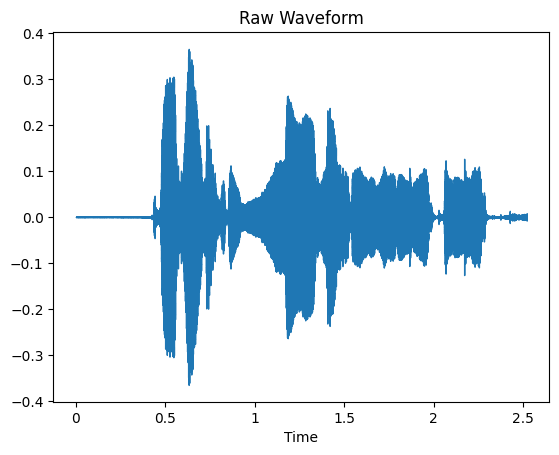

In [39]:
# plotting audio
librosa.display.waveshow(y=audio_row_index["audio"], sr=audio_row_index["samplerate"])
plt.title("Raw Waveform")
plt.show()

In [40]:
# Converting MONO and downsampling

def down_sampling_mono_audio(audio_array, original_sr, target_sr=22050):
    """
    Processes raw audio array:
    - Converts to mono (averages channels if stereo)
    - Resamples to target_sr
    """
    # Ensure mono
    if audio_array.ndim == 2:
        audio_array = np.mean(audio_array, axis=0)  # stereo to mono

    # Resample if needed
    if original_sr != target_sr:
        audio_array = librosa.resample(audio_array, orig_sr=original_sr, target_sr=target_sr)

    return audio_array, target_sr


1


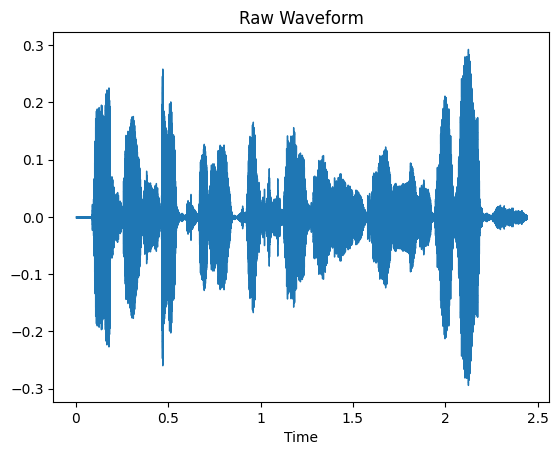

The Audio waveform: 
 [0.00032529 0.00057148 0.00050432 ... 0.00051504 0.00032627 0.000403  ] (53846,)
the sample rate: 
 22050


In [44]:
random_audio_index = random.randint(0, len(manatts_dataset["audio"]))
audio_row_index = manatts_dataset.iloc[random_audio_index]
print(audio_row_index["audio"].ndim)
y, sr = down_sampling_mono_audio(audio_row_index["audio"], original_sr=audio_row_index["samplerate"])

librosa.display.waveshow(y=y, sr=sr)
plt.title("Raw Waveform")
plt.show()
print("The Audio waveform: \n", y, y.shape)
print("the sample rate: \n", sr)

In [41]:
# Normalization audio array

def normalize_audio(audio_array):
    """
    Normalize audio to have max absolute value of 1.0, peak normalization
    """
    max_val = np.max(np.abs(audio_array))
    if max_val > 0:
        return audio_array / max_val
    return audio_array  # already silent or zero


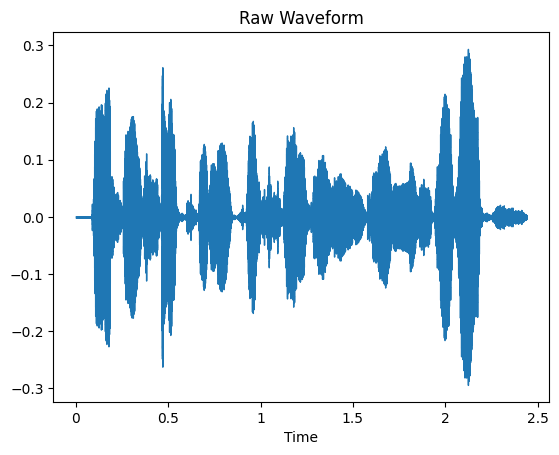

The Audio waveform: 
 [0.00039673 0.0005188  0.00054932 ... 0.00030518 0.00033569 0.0005188 ] (107692,)


In [46]:

librosa.display.waveshow(y=audio_row_index["audio"], sr=audio_row_index["samplerate"])
plt.title("Raw Waveform")
plt.show()
print("The Audio waveform: \n", audio_row_index["audio"], audio_row_index["audio"].shape)


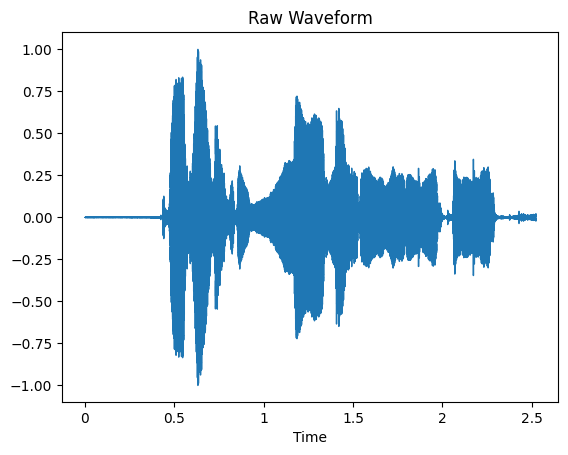

The Audio waveform: 
 [ 8.36190317e-05  0.00000000e+00  0.00000000e+00 ... -1.16230454e-02
 -1.32118070e-02 -1.41316164e-02] (111176,)


In [42]:
y = normalize_audio(audio_row_index["audio"])

librosa.display.waveshow(y=y, sr=audio_row_index["samplerate"])
plt.title("Raw Waveform")
plt.show()

print("The Audio waveform: \n", y, y.shape)


In [44]:
# trimming silence
def trim_silence(audio, top_db=30):
    """
    Trims leading and trailing silence from an audio signal.
    top_db: the threshold (in decibels) below reference to consider as silence.
    """
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=top_db)
    return trimmed_audio


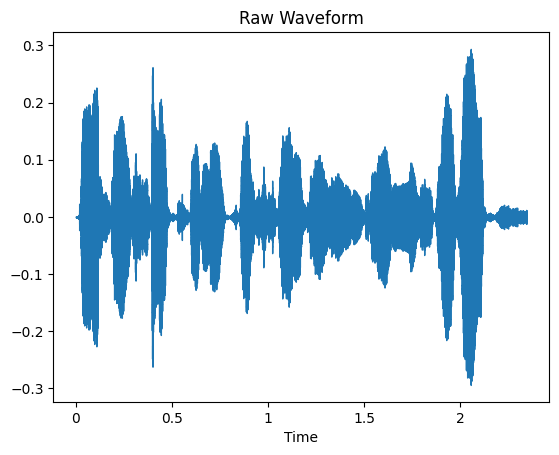

The Audio waveform: 
 [ 6.10351562e-05  6.10351562e-05  0.00000000e+00 ... -4.60815430e-03
 -4.08935547e-03 -3.84521484e-03] (103424,)


In [49]:
y = trim_silence(audio_row_index["audio"])

librosa.display.waveshow(y=y, sr=audio_row_index["samplerate"])
plt.title("Raw Waveform")
plt.show()

print("The Audio waveform: \n", y, y.shape)

In [45]:
# denosing audio
def reduce_noise(audio, sr):
    """
    Apply noise reduction using spectral gating
    """
    # Estimate noise from the first 0.5 sec
    noise_sample = audio[:int(0.5 * sr)]
    return nr.reduce_noise(y=audio, y_noise=noise_sample, sr=sr)


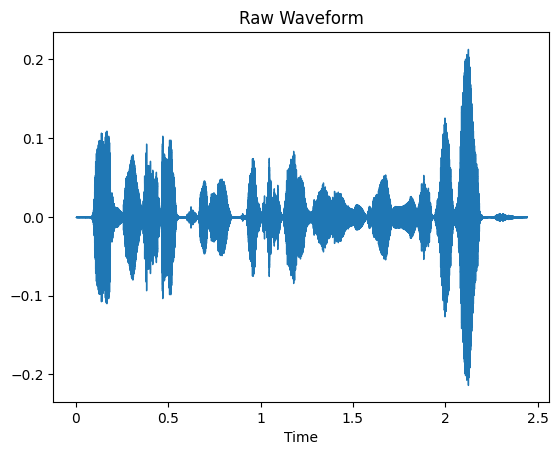

The Audio waveform: 
 [ 5.38051288e-05  3.39986779e-05  3.30205676e-05 ... -1.01103841e-05
 -1.27787304e-05  3.66829843e-05] (107692,)


In [51]:
y = reduce_noise(audio_row_index["audio"], audio_row_index["samplerate"])

librosa.display.waveshow(y=y, sr=audio_row_index["samplerate"])
plt.title("Raw Waveform")
plt.show()

print("The Audio waveform: \n", y, y.shape)

In [52]:
print("The Transcript is: \n", audio_row_index["transcript"])
print("The Hypothesis is: \n", audio_row_index["hypothesis"])

print("before denoising")
ipd.Audio(audio_row_index["audio"], rate=audio_row_index["samplerate"])


The Transcript is: 
 با دو سه کلیک ساده انجام می‌شود، 
The Hypothesis is: 
 با دو سه کلی ک ساده انجام می شود
before denoising


In [53]:
print("after denoising")
ipd.Audio(y, rate=audio_row_index["samplerate"])

after denoising


In [46]:
# normalizing the loudness

def normalize_loudness(audio, sr, target_lufs=-23.0):
    """
    Normalize loudness to a target LUFS level
    """
    meter = pyln.Meter(sr)  # Create LUFS meter
    loudness = meter.integrated_loudness(audio)
    return pyln.normalize.loudness(audio, loudness, target_lufs)

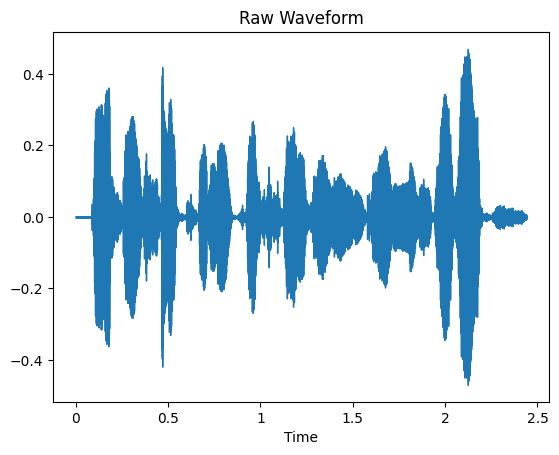

The Audio waveform: 
 [0.00063422 0.00082936 0.00087814 ... 0.00048786 0.00053664 0.00082936] (107692,)


In [55]:
y = normalize_loudness(audio_row_index["audio"], audio_row_index["samplerate"])

librosa.display.waveshow(y=y, sr=audio_row_index["samplerate"])
plt.title("Raw Waveform")
plt.show()

print("The Audio waveform: \n", y, y.shape)
ipd.Audio(y, rate=audio_row_index["samplerate"])


In [ ]:
# =============================
# Audio Preprocessing Pipeline
# =============================

def preprocess_audio_pipeline(audio_array, original_sr, target_sr=22050, target_lufs=-23.0):
    """
    Full pipeline to process audio from a dataset row.
    """
    

    # Step 1: Convert to mono + resample
    audio_array, _ = down_sampling_mono_audio(audio_array, original_sr, target_sr)

    # Step 2: Trim silence
    audio_array = trim_silence(audio_array)

    # Step 3: Denoise
    audio_array = reduce_noise(audio_array, sr=target_sr)

    # Step 4: Normalize loudness
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        audio_array = normalize_loudness(audio_array, sr=target_sr, target_lufs=target_lufs)

    # Step 5: Peak normalization
    audio_array = normalize_audio(audio_array)

    audio_array = np.clip(audio_array, -1.0, 1.0)

    return audio_array


# Apply pipeline to the 'audio' column
manatts_dataset['processed_audio'] = manatts_dataset.progress_apply(lambda row: preprocess_audio_pipeline(row["audio"], row["samplerate"]), axis=1)

100%|██████████| 4992/4992 [09:06<00:00,  9.14it/s]


In [48]:
len(manatts_dataset)

4992

In [49]:
manatts_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   file name        4992 non-null   object 
 1   transcript       4992 non-null   object 
 2   duration         4992 non-null   float64
 3   match quality    4992 non-null   object 
 4   hypothesis       4992 non-null   object 
 5   CER              4992 non-null   float64
 6   search type      4992 non-null   int64  
 7   ASRs             4992 non-null   object 
 8   audio            4992 non-null   object 
 9   samplerate       4992 non-null   float64
 10  transcript_len   4992 non-null   int64  
 11  processed_text   4992 non-null   object 
 12  processed_audio  4992 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 507.1+ KB


**Converting audio array into wavs format and saving in a directory**

In [50]:
# Directory to save WAV files
output_dir = "/kaggle/working/manatts_dataset_training/wavs"
os.makedirs(output_dir, exist_ok=True)

In [51]:

# Save WAV files and create new audio path column
def save_audio_file(row, index):
    audio_path = os.path.join(output_dir, f"utt_{index:05d}.wav")
    sf.write(audio_path, row["processed_audio"], samplerate=22050)  # or your actual SR
    return audio_path

manatts_dataset["audio_path"] = [save_audio_file(row, i) for i, row in manatts_dataset.iterrows()]


**Storing in dataset folder**

In [ ]:
# Save preprocessed DataFrame
manatts_dataset.to_parquet("/kaggle/working/manatts_dataset_training/processed_audio/preprocessed_manatts.parquet", index=False)

# Model Training config

for training Tacotron2 and HIFI-GAN we need audio folder and metadata.csv and also we should split our dataset into train, test, valid too.

making dataset folder for training

1- making a wav folder\
2- making metadata

it should be like this:

your_project/ \
├── config.json  # (can use pretrained and finetune)\
├── metadata.csv\
└── wavs/\
    ├── audio1.wav\
    ├── audio2.wav

the metadata are three name: train.csv, test.csv, valid.csv


In [9]:
manatts_dataset = pd.read_parquet("/kaggle/working/manatts_dataset_training/processed_audio/preprocessed_manatts.parquet")
print(manatts_dataset.sample(5))

        file name                                         transcript  \
401    416-24.wav  که دارای صفحه‌خوان بود، او سرانجام این امکان ر...   
1108   402-68.wav  خوانده شود تا افراد نابینا یا کم‌بینا همان درک...   
2517   280-44.wav         یک مجموعه قانونی لازم‌الاجرا در کشور است،    
3212  518-113.wav  انواع اینترنت‌بانک، همراه‌بانک و اپلیکیشن انتق...   
1447   222-48.wav          جدایی پدر از همسر جدید و بحران خانوادگی:    

      duration match quality  \
401   7.380000        MIDDLE   
1108  5.193991        MIDDLE   
2517  3.363991          HIGH   
3212  5.848980        MIDDLE   
1447  4.028980          HIGH   

                                             hypothesis       CER  \
401   ک دارای صفر خان بود اسرانجام این امکان را داشت...  0.080808   
1108  خانده شود تا افراد نابینا یا کمبین ا هم درکی ر...  0.084507   
2517          یک مجموعه قانونی لازم ال اجرا در کشور است  0.025000   
3212  امووع اینترنت بانک همراه بانک و پلیکیشن‌های ان...  0.150000   
1447            جدایی پدر از 

In [6]:
y, sr = librosa.load("/kaggle/working/manatts_dataset_training/wavs/utt_00009.wav")

ipd.Audio(y, rate=sr)
# print(y, y.shape)

In [ ]:
df = manatts_dataset[["audio_path", "processed_text"]]

# Rename columns to match expected format
df.columns = ["audio_path", "transcription"]

# Split into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


# Save splits
train_df.to_csv("/kaggle/working/manatts_dataset_training/metadata_train.csv", sep="|", header=False, index=False)
valid_df.to_csv("/kaggle/working/manatts_dataset_training/metadata_valid.csv", sep="|", header=False, index=False)
test_df.to_csv("/kaggle/working/manatts_dataset_training/metadata_test.csv", sep="|", header=False, index=False)


making tacotron2 and hifi-gan config


In [ ]:

# Tacotron2 config
tacotron2_config = {
    "output_directory": "/kaggle/working/tacotron2_output",
    "epochs": 1000,
    "batch_size": 32,
    "learning_rate": 1e-3,
    "dataset": {
        "metadata_path": "/kaggle/working/manatts_dataset_training/metadata_train.csv",
        "validation_metadata_path": "/kaggle/working/manatts_dataset_training/metadata_valid.csv",
        "audio_path": "/kaggle/working/manatts_dataset_training/wavs",
        "text_cleaners": ["basic_cleaners"]
    },
    "model": {
        "n_mel_channels": 80,
        "n_symbols": 40,
        "symbols_embedding_dim": 512,
        "encoder_embedding_dim": 512,
        "decoder_rnn_dim": 1024,
        "attention_rnn_dim": 1024,
        "attention_dim": 128,
        "prenet_dim": 256,
        "max_decoder_steps": 1000,
        "gate_threshold": 0.5,
        "p_attention_dropout": 0.1,
        "p_decoder_dropout": 0.1
    }
}

# HiFi-GAN config
hifigan_config = {
    "train_filelist": "/kaggle/working/manatts_dataset_training/metadata_train.csv",
    "valid_filelist": "/kaggle/working/manatts_dataset_training/metadata_valid.csv",
    "sampling_rate": 22050,
    "hop_size": 256,
    "win_size": 1024,
    "num_mels": 80,
    "fmin": 0,
    "fmax": 8000,
    "batch_size": 16,
    "learning_rate": 1e-4,
    "epochs": 1000
}

# Save configs
with open("/kaggle/working/manatts_dataset_training/tacotron2_config.yaml", "w", encoding='utf-8') as f:
    yaml.dump(tacotron2_config, f, sort_keys=False, allow_unicode=True)

with open("/kaggle/working/manatts_dataset_training/hifigan_config.yaml", "w", encoding='utf-8') as f:
    yaml.dump(hifigan_config, f, sort_keys=False, allow_unicode=True)

print("Configs saved: tacotron2_config.yaml, hifigan_config.yaml")
